In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt

# File Loading of PC/PS

This is slightly annoying because the `Om` is not the same. I have to do some string manipulation.
1. For each file in the PS directory, look for the counterpart in the PC directory.
2. Load the data into lists where for index i, PS[i] and PC[i] come from the same model.

In [2]:
# I'm running this locally, change to /tigress/jialiu/zack/ if you're on tigress
data_dir = '/Users/zequnl/Projects/neutrino_mpk/'
PS_directory = data_dir + 'powerspectrum'
PC_directory = data_dir + 'peakcounts'

# this code finds all the filenames and puts them in a list
PS_names, PC_names = [], []
for filename in os.listdir(PS_directory):
    if filename.endswith(".npy"): 
        PS_names.append(filename)
for filename in os.listdir(PC_directory):
    if filename.endswith(".npy"): 
        PC_names.append(filename)
print('Found', len(PS_names), 'PS files and', len(PC_names), 'PC files.')

def get_As( string_with_As ):
    return float(string_with_As.split('_As')[1].split('_mva')[0])

def get_filenames_PS_PC( input_As ):
    PS_filename_candidates = [x for x in PS_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    PC_filename_candidates = [x for x in PC_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    if len(PS_filename_candidates) == 1 and len(PC_filename_candidates) == 1:
        return PS_filename_candidates[0], PC_filename_candidates[0]
    else:
        print("multiple file candidates found! possibly fiducial model 1a/1b")
        return None

Found 101 PS files and 101 PC files.


In [3]:
from astropy.table import Table
t = Table.read(data_dir + 'cosmological_parameters.txt', format='ascii')

PS_filename_list_temp = []
PC_filename_list_temp = []
for row in t:
    # special cases (fiducial 1 and 2)
    if '1a(fiducial)' in row['Model']:
        PS_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50.npy'
        PC_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S.npy'
    elif '1b(fiducial)' in row['Model']:
        PS_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50.npy'
        PC_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S.npy'
    else:
        PS_name, PC_name = get_filenames_PS_PC(row['10^9*A_s'])
    
    PS_filename_list_temp.append(PS_name)
    PC_filename_list_temp.append(PC_name)

# put the filenames in the table for easy access
t['PS'] = np.array(PS_filename_list_temp)
t['PC'] = np.array(PC_filename_list_temp)

# show the table
t

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str82,str81
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S.npy


## Computing Means and Covariance
We want to use prepare the mean PS and PC here. I just use a bunch of lists. I have to remove the elements which are 0, so I truncate the first 5 off.

In [4]:
PS_means = []
PC_means = []

for row in t:
    PS_arr = np.load( PS_directory + r'/' + row['PS'] )[:,5:]
    PC_arr = np.load( PC_directory + r'/' + row['PC'] )
    
    # first row of PS_arr is ell
    ell = PS_arr[0,:]
    PS_realizations = PS_arr[1:,:]
    # first and second row of PC are kappa, SNR
    kappa = PS_arr[0,:]
    SNR = PS_arr[1,:]
    PC_realizations = PC_arr[2:,:]
    
    if row['Model'] == '1a(fiducial)':
        print('shapes,',PS_realizations.shape, PC_realizations.shape)
        PS_cov = np.cov(PS_realizations.T)
        PC_cov = np.cov(PC_realizations.T)
    
    PS_means.append( np.mean(PS_realizations, axis=0) )
    PC_means.append( np.mean(PC_realizations, axis=0) )
    

shapes, (1000, 45) (1000, 200)


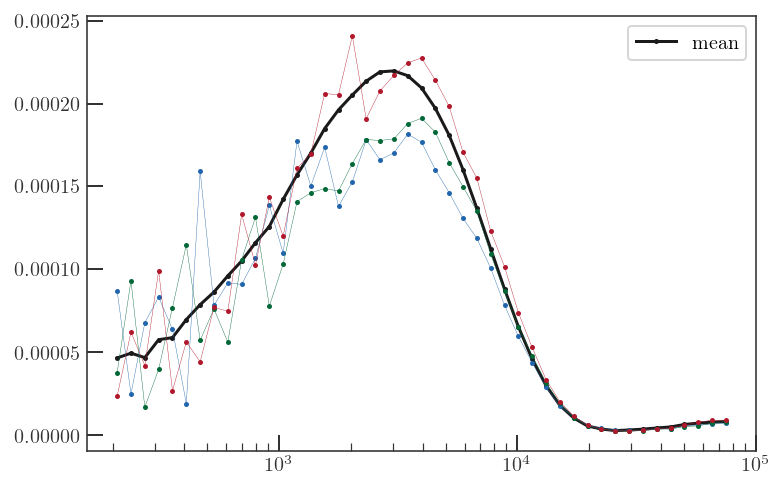

In [5]:
plt.plot( ell, ell*(ell+1)/np.pi * PS_means[0], label='mean' )

PS_arr = np.load( PS_directory + r'/' + t[0]['PS'] )[:,5:]
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[1], lw=0.2 )
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[2], lw=0.2 )
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[3], lw=0.2 )

plt.xscale('log')
plt.legend()
# plt.yscale('log')

## Interpolator

In [6]:
from forecast import buildInterpolator
obsarr = np.array( PS_means ) 
params = np.array( [t['M_nu(eV)'], t['Omega_m'], t['10^9*A_s']] ).T
print(obsarr.shape)
print(params.shape)

(101, 45)
(101, 3)


In [7]:
interp = buildInterpolator(obsarr, params)

## Probability Function
write down a probability function, where $P=\exp(-0.5(d-\mu)^{T}C^{-1}(d-u))$
 where d is the average PS/PC from the fiducial model (M_nu = 0.1 eV)

In [8]:
def P( mu ):
    mu = interp( mu )
    # NOTE: 45 here means refers to bins-5, since first 5 are bad
    mu = np.array(list(mu.tolist())).reshape(45,) 
    d = obsarr[1]
    return np.exp( -0.5 * np.dot( np.dot( (d - mu).T, \
                                     np.linalg.inv(PS_cov) ), (d-mu) )  )

In [9]:
sigma1 = np.std(t['M_nu(eV)'])
sigma2 = np.std(t['Omega_m'])
sigma3 = np.std(t['10^9*A_s'])
mean1 = np.mean(t['M_nu(eV)'])
mean2 = np.mean(t['Omega_m'])
mean3 = np.mean(t['10^9*A_s'])

mult = 1.5
values1 = np.linspace(mean1-mult*sigma1, mean1+mult*sigma1, 30)
values2 = np.linspace(mean2-mult*sigma2, mean2+mult*sigma2, 30)
values3 = np.linspace(mean3-mult*sigma3, mean3+mult*sigma3, 30)

# construct a 30x30x30 cube
cube = np.zeros((30,30,30))
for i1, value1 in enumerate( values1 ):
    for i2, value2 in enumerate( values2 ):
        for i3, value3 in enumerate( values3 ):
            cube[i1,i2,i3] = P( (value1, value2, value3) )


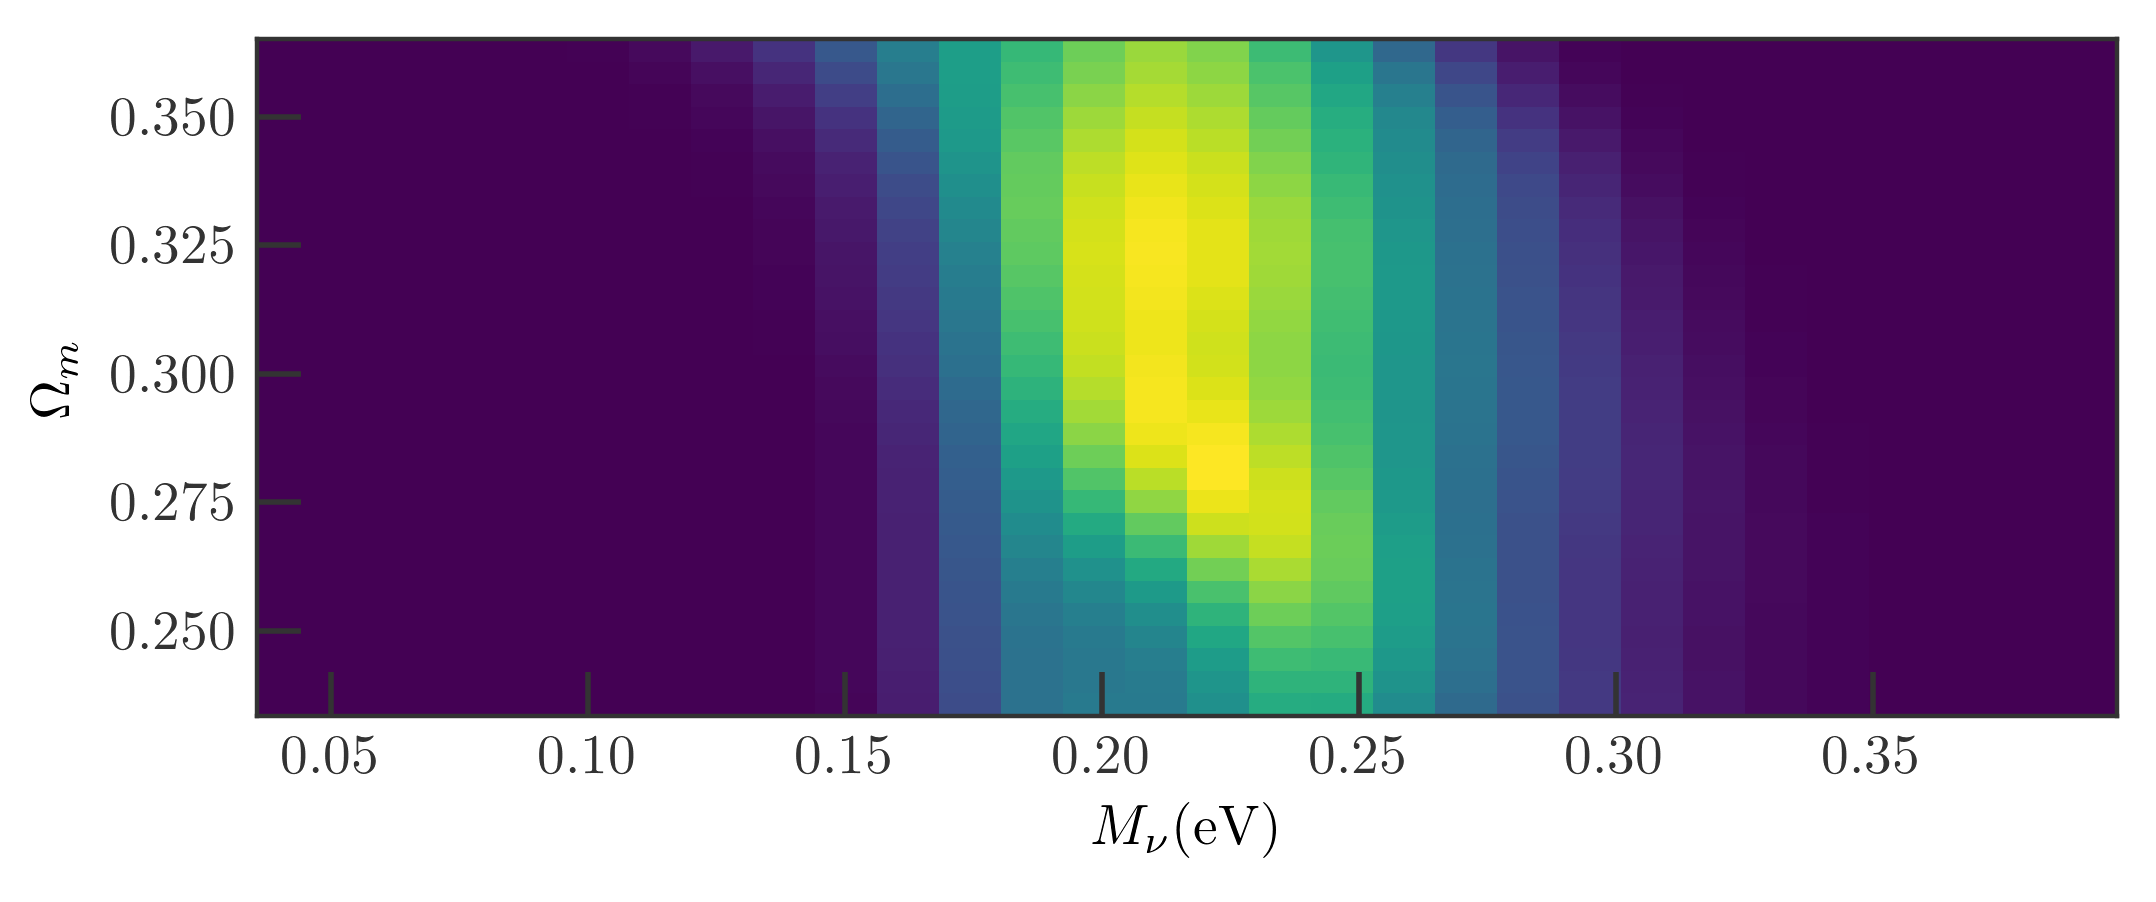

In [13]:

# marginalize over one axis, here I choose over A_s
square = np.sum( cube, axis=2 )

plt.figure(dpi=200)
plt.imshow(square,interpolation='nearest',\
          extent=(np.min(values1), np.max(values1), \
                 np.min(values2), np.max(values2)))
plt.xlabel(r'$M_{\nu}$(eV)')
plt.ylabel(r'$\Omega_m$');